In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
from pprint import pprint
import calendar
from calendar import month_abbr
import datetime as dt

In [2]:
Weather_Path = "Clean Data/SAWeatherAll.csv"
Drought_Path = "Clean Data/dm_export_20160705_20220705.csv"
J17_Well_Path = "Clean Data/j17.csv"


Weather_Data_df = pd.read_csv(Weather_Path, encoding="utf-8")
Drought_Data_df = pd.read_csv(Drought_Path, encoding="utf-8")
J17_Well_Data_df = pd.read_csv(J17_Well_Path, encoding="utf-8")

In [3]:
Weather_Data_df

,Unnamed: 0,Month,Day,Year,Temp Max,Temp Avg,Temp Min,Humidity Max,Humidity Avg,Humidity Min,Precipitation
0,0,Jan,1,2016,49,46.3,44,73,61.5,51,0.00
1,1,Jan,2,2016,48,45.0,43,93,67.2,48,0.00
2,2,Jan,3,2016,61,47.7,35,96,75.6,49,0.22
3,3,Jan,4,2016,57,42.7,33,93,67.6,37,0.00
4,4,Jan,5,2016,57,44.9,30,96,74.4,55,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2398,207,Jul,27,2022,101,86.5,74,93,61.2,28,0.00
2399,208,Jul,28,2022,100,86.2,76,94,63.1,31,0.00
2400,209,Jul,29,2022,100,86.8,76,94,63.0,31,0.00
2401,210,Jul,30,2022,100,87.6,73,96,56.7,27,0.00


In [4]:
#only run this ONCE you will get an error if you dont restart the kernel
#changes the months in month_abbr to lower case
lower_ma = [m.lower() for m in month_abbr]

#changes the months in df to lowercase and maps the values to numerical months
Weather_Data_df['Month'] = Weather_Data_df['Month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')


In [5]:
#uses the apply method to merge our numerical month values into one column
cols=["Month", "Day", "Year"]
Weather_Data_df['Date'] = Weather_Data_df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")

Weather_Data_df = Weather_Data_df.drop(columns = ["Month", "Day", "Year", "Unnamed: 0"])

Weather_Data_df["Date"] = pd.to_datetime(Weather_Data_df["Date"])

In [6]:
Weather_Data_df.dtypes

Temp Max                  int64
Temp Avg                float64
Temp Min                  int64
Humidity Max              int64
Humidity Avg            float64
Humidity Min              int64
Precipitation           float64
Date             datetime64[ns]
dtype: object

In [7]:
#we only need to filter for last 5 years
# double check and ensure its J17 only
#clean it 

J17_Well_Data_df = J17_Well_Data_df.dropna()
J17_Well_Data_df

,Site,DailyHighDate,WaterLevelElevation
0,J17WL,7/5/2022,635.98
1,J17WL,7/4/2022,636.85
2,J17WL,7/3/2022,637.15
3,J17WL,7/2/2022,636.71
4,J17WL,7/1/2022,636.55
...,...,...,...
2373,J17WL,1/5/2016,667.55
2374,J17WL,1/4/2016,667.70
2375,J17WL,1/3/2016,666.69
2376,J17WL,1/2/2016,666.37


In [8]:
J17_Well_Data_df = J17_Well_Data_df.dropna()
J17_Well_Data_df["DailyHighDate"]= pd.to_datetime(J17_Well_Data_df["DailyHighDate"])
J17_Well_Data_df.dtypes

Site                           object
DailyHighDate          datetime64[ns]
WaterLevelElevation           float64
dtype: object

In [9]:
#create bins for aquifer water level
waterlevel = [0, 639, 649, 659, 700]

# Create the names for what restriction the city will be placed under based on water level
restriction = ["restriction 3", "restriction 2", "restriction 1", "no restriction"]

#create a new column for restriction level, we can filter based off these later
J17_Well_Data_df["Restriction Level"] = pd.cut(J17_Well_Data_df["WaterLevelElevation"], waterlevel, labels=restriction)

In [10]:
J17_Well_Data_df

,Site,DailyHighDate,WaterLevelElevation,Restriction Level
0,J17WL,2022-07-05,635.98,restriction 3
1,J17WL,2022-07-04,636.85,restriction 3
2,J17WL,2022-07-03,637.15,restriction 3
3,J17WL,2022-07-02,636.71,restriction 3
4,J17WL,2022-07-01,636.55,restriction 3
...,...,...,...,...
2373,J17WL,2016-01-05,667.55,no restriction
2374,J17WL,2016-01-04,667.70,no restriction
2375,J17WL,2016-01-03,666.69,no restriction
2376,J17WL,2016-01-02,666.37,no restriction


In [11]:
#Change to datetime
Drought_Data_df[['ValidStart','ValidEnd']] = Drought_Data_df[['ValidStart','ValidEnd']].apply(pd.to_datetime)
Drought_Data_df.dtypes

MapDate                       int64
FIPS                          int64
County                       object
State                        object
None                        float64
D0                          float64
D1                          float64
D2                          float64
D3                          float64
D4                          float64
ValidStart           datetime64[ns]
ValidEnd             datetime64[ns]
StatisticFormatID             int64
dtype: object

In [12]:
Drought_Data_df

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
0,20220705,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,27.38,2022-07-05,2022-07-11,1
1,20220628,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,49.45,2022-06-28,2022-07-04,1
2,20220621,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,49.45,2022-06-21,2022-06-27,1
3,20220614,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,49.45,2022-06-14,2022-06-20,1
4,20220607,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,10.40,2022-06-07,2022-06-13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,20160802,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-08-02,2016-08-08,1
310,20160726,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-07-26,2016-08-01,1
311,20160719,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-07-19,2016-07-25,1
312,20160712,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-07-12,2016-07-18,1


# Filtering Data

In [13]:
#for aquifer data the most recent date we have is 2022-07-05, filter accordingly to get 5 yrs worth of data
#we do this for all 3 data sets we have
Weather_Data_2016_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2016-07-05") & (Weather_Data_df["Date"] <= "2016-12-31")]
Weather_Data_2017_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2017-01-01") & (Weather_Data_df["Date"] <= "2017-12-31")]
Weather_Data_2018_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2018-01-01") & (Weather_Data_df["Date"] <= "2018-12-31")]
Weather_Data_2019_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2019-01-01") & (Weather_Data_df["Date"] <= "2019-12-31")]
Weather_Data_2020_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2020-01-01") & (Weather_Data_df["Date"] <= "2020-12-31")]
Weather_Data_2021_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2021-01-01") & (Weather_Data_df["Date"] <= "2021-12-31")]
Weather_Data_2022_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2022-01-01") & (Weather_Data_df["Date"] <= "2022-07-05")]

In [14]:
J17_2016_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2016-07-05") & (J17_Well_Data_df["DailyHighDate"] <= "2016-12-31")]
J17_2017_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2017-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2017-12-31")]
J17_2018_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2018-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2018-12-31")]
J17_2019_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2019-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2019-12-31")]
J17_2020_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2020-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2020-12-31")]
J17_2021_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2021-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2021-12-31")]
J17_2022_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2022-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2022-07-05")]


In [15]:
Drought_Data_2016_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2016-07-05") & (Drought_Data_df["ValidEnd"] <= "2016-12-31")]
Drought_Data_2017_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2017-01-01") & (Drought_Data_df["ValidEnd"] <= "2017-12-31")]
Drought_Data_2018_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2018-01-01") & (Drought_Data_df["ValidEnd"] <= "2018-12-31")]
Drought_Data_2019_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2019-01-01") & (Drought_Data_df["ValidEnd"] <= "2019-12-31")]
Drought_Data_2020_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2020-01-01") & (Drought_Data_df["ValidEnd"] <= "2020-12-31")]
Drought_Data_2021_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2021-01-01") & (Drought_Data_df["ValidEnd"] <= "2021-12-31")]
Drought_Data_2022_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2022-01-01") & (Drought_Data_df["ValidEnd"] <= "2022-12-31")]

In [16]:
Drought_Data_2016_df

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
289,20161220,48029,Bexar County,TX,100.00,0.00,0.0,0.0,0.0,0.0,2016-12-20,2016-12-26,1
290,20161213,48029,Bexar County,TX,100.00,0.00,0.0,0.0,0.0,0.0,2016-12-13,2016-12-19,1
291,20161206,48029,Bexar County,TX,100.00,0.00,0.0,0.0,0.0,0.0,2016-12-06,2016-12-12,1
292,20161129,48029,Bexar County,TX,97.54,2.46,0.0,0.0,0.0,0.0,2016-11-29,2016-12-05,1
293,20161122,48029,Bexar County,TX,97.54,2.46,0.0,0.0,0.0,0.0,2016-11-22,2016-11-28,1
294,20161115,48029,Bexar County,TX,97.89,2.11,0.0,0.0,0.0,0.0,2016-11-15,2016-11-21,1
295,20161108,48029,Bexar County,TX,92.85,7.15,0.0,0.0,0.0,0.0,2016-11-08,2016-11-14,1
296,20161101,48029,Bexar County,TX,95.41,4.59,0.0,0.0,0.0,0.0,2016-11-01,2016-11-07,1
297,20161025,48029,Bexar County,TX,100.00,0.00,0.0,0.0,0.0,0.0,2016-10-25,2016-10-31,1
298,20161018,48029,Bexar County,TX,100.00,0.00,0.0,0.0,0.0,0.0,2016-10-18,2016-10-24,1


In [64]:
J17_2020_df.drop_duplicates()
J17_2020_df
#Weather_Data_2020_df

,Site,DailyHighDate,WaterLevelElevation,Restriction Level
551,J17WL,2020-12-31,663.32,no restriction
552,J17WL,2020-12-30,662.85,no restriction
553,J17WL,2020-12-29,662.93,no restriction
554,J17WL,2020-12-28,663.00,no restriction
555,J17WL,2020-12-27,663.30,no restriction
...,...,...,...,...
912,J17WL,2020-01-05,671.66,no restriction
913,J17WL,2020-01-04,671.69,no restriction
914,J17WL,2020-01-03,671.81,no restriction
915,J17WL,2020-01-02,672.13,no restriction


In [69]:
#Drought_Data_df
#Drought_Data_df.groupby(by=[Drought_Data_df.index.month])
#Drought_Data_df[Drought_Data_df['ValidStart'] == ""]
Drought_2016_July = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2016-07-05") & (Drought_Data_df["ValidStart"] <= "2016-7-31")]
# Groupby Month and do the avg. for each month which will be utilized for daily avg. value
Drought_2016_July

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
310,20160726,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.0,2016-07-26,2016-08-01,1
311,20160719,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.0,2016-07-19,2016-07-25,1
312,20160712,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.0,2016-07-12,2016-07-18,1
313,20160705,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.0,2016-07-05,2016-07-11,1


In [18]:
#After we have cleaned data we will do the 10- day bucket sort to compare water days restrictons(SAWS uses a 10 day)

#we are looking for the date and a "drought level" (D01, D02, D03, D04) we will use both J17_well_Data_df and Drought_Data_df

#use .loc 

In [19]:
#based on new data, start analyzing if the following day had higher vs lower vs equal compared to the restriction day.
#It will be a For loop thru previous cell using the +1



#Final data will be used to creat plots

In [65]:
Drought_Data_merge_df = pd.concat([Drought_Data_2016_df, Drought_Data_2017_df, Drought_Data_2018_df, Drought_Data_2019_df, Drought_Data_2020_df, Drought_Data_2021_df, Drought_Data_2022_df], axis=0)
Drought_Data_merge_df

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
289,20161220,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.0,2016-12-20,2016-12-26,1
290,20161213,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.0,2016-12-13,2016-12-19,1
291,20161206,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.0,2016-12-06,2016-12-12,1
292,20161129,48029,Bexar County,TX,97.54,2.46,0.00,0.00,0.0,0.0,2016-11-29,2016-12-05,1
293,20161122,48029,Bexar County,TX,97.54,2.46,0.00,0.00,0.0,0.0,2016-11-22,2016-11-28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,20220201,48029,Bexar County,TX,0.00,100.00,100.00,18.68,0.0,0.0,2022-02-01,2022-02-07,1
23,20220125,48029,Bexar County,TX,0.00,100.00,100.00,3.10,0.0,0.0,2022-01-25,2022-01-31,1
24,20220118,48029,Bexar County,TX,0.00,100.00,46.20,0.00,0.0,0.0,2022-01-18,2022-01-24,1
25,20220111,48029,Bexar County,TX,0.00,100.00,1.72,0.00,0.0,0.0,2022-01-11,2022-01-17,1


In [82]:
Weather_Data_Total_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2016-07-05") & (Weather_Data_df["Date"] <= "2022-07-05")]
Weather_Data_Total_df

,Temp Max,Temp Avg,Temp Min,Humidity Max,Humidity Avg,Humidity Min,Precipitation,Date
186,98,86.0,79,90,70.3,43,0.0,2016-07-05
187,98,85.2,79,90,70.6,41,0.0,2016-07-06
188,98,85.2,78,90,70.1,42,0.0,2016-07-07
189,98,86.1,79,88,67.0,39,0.0,2016-07-08
190,98,85.5,77,96,70.2,39,0.0,2016-07-09
...,...,...,...,...,...,...,...,...
2372,93,83.3,72,93,66.7,42,0.0,2022-07-01
2373,99,86.5,77,96,65.0,32,0.0,2022-07-02
2374,99,86.8,77,94,62.7,30,0.0,2022-07-03
2375,99,84.6,75,96,67.7,33,0.0,2022-07-04


In [87]:
#J17_Well_Data_df
J17_Well_Data_Total_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2016-07-05") & (J17_Well_Data_df["DailyHighDate"] <= "2022-07-05")]
J17_Well_Final_Data = J17_Well_Data_Total_df.loc[(J17_Well_Data_df["DailyHighDate"] != "2020-11-08")]
J17_Well_Final_Data

,Site,DailyHighDate,WaterLevelElevation,Restriction Level
0,J17WL,2022-07-05,635.98,restriction 3
1,J17WL,2022-07-04,636.85,restriction 3
2,J17WL,2022-07-03,637.15,restriction 3
3,J17WL,2022-07-02,636.71,restriction 3
4,J17WL,2022-07-01,636.55,restriction 3
...,...,...,...,...
2187,J17WL,2016-07-09,670.67,no restriction
2188,J17WL,2016-07-08,671.13,no restriction
2189,J17WL,2016-07-07,671.84,no restriction
2190,J17WL,2016-07-06,672.72,no restriction


In [ ]:
Weather_Data_Total_df.loc[(Weather_Data_Total_df["DailyHighDate"] != "2020-11-08")]

In [79]:
#Drought_well_merge = pd.concat([J17_merge_df, ])
mask = Drought_Data_df.loc[(Drought_Data_df['ValidStart'].dt.month == int(7))]#.mean()
mask

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
0,20220705,48029,Bexar County,TX,0.00,100.00,100.00,100.00,100.0,27.38,2022-07-05,2022-07-11,1
49,20210727,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-27,2021-08-02,1
50,20210720,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-20,2021-07-26,1
51,20210713,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-13,2021-07-19,1
52,20210706,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-06,2021-07-12,1
101,20200728,48029,Bexar County,TX,14.89,85.11,0.00,0.00,0.0,0.00,2020-07-28,2020-08-03,1
102,20200721,48029,Bexar County,TX,0.00,100.00,0.00,0.00,0.0,0.00,2020-07-21,2020-07-27,1
103,20200714,48029,Bexar County,TX,0.00,100.00,0.00,0.00,0.0,0.00,2020-07-14,2020-07-20,1
104,20200707,48029,Bexar County,TX,0.45,99.55,0.00,0.00,0.0,0.00,2020-07-07,2020-07-13,1
153,20190730,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2019-07-30,2019-08-05,1


Text(0, 0.5, 'Water Level')

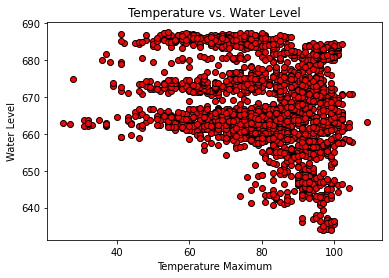

In [88]:
#
#Plot a bar chart using Temperature vs Water level to show correlation
Scatter_temp_merge = Weather_Data_Total_df['Temp Max']
Scatter_waterlvl_merge = J17_Well_Final_Data['WaterLevelElevation']
plt.scatter(Scatter_temp_merge, Scatter_waterlvl_merge, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")
#explorepossible analysis

Text(0, 0.5, 'Water Level')

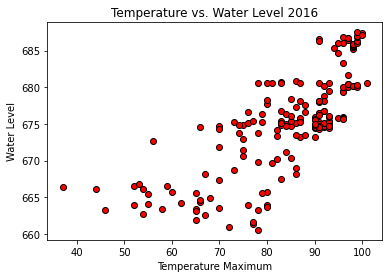

In [54]:
#
#Plot a bar chart using Temperature vs Water level to show correlation
Scatter_temp16 = Weather_Data_2016_df['Temp Max']
Scatter_waterlvl16 = J17_2016_df['WaterLevelElevation']
plt.scatter(Scatter_temp16, Scatter_waterlvl16, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level 2016")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")
#explorepossible analysis

Text(0, 0.5, 'Water Level')

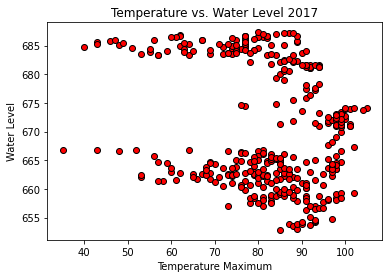

In [44]:
Scatter_temp17 = Weather_Data_2017_df['Temp Max']
Scatter_waterlvl17 = J17_2017_df['WaterLevelElevation']
plt.scatter(Scatter_temp17, Scatter_waterlvl17, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level 2017")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")

Text(0, 0.5, 'Water Level')

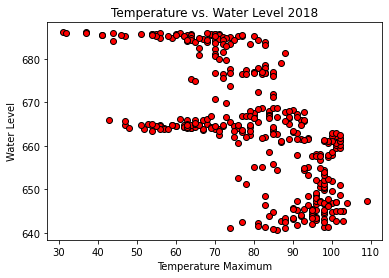

In [55]:
Scatter_temp18 = Weather_Data_2018_df['Temp Max']
Scatter_waterlvl18 = J17_2018_df['WaterLevelElevation']
plt.scatter(Scatter_temp18, Scatter_waterlvl18, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level 2018")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")

Text(0, 0.5, 'Water Level')

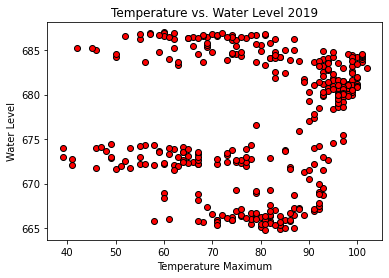

In [56]:
Scatter_temp19 = Weather_Data_2019_df['Temp Max']
Scatter_waterlvl19 = J17_2019_df['WaterLevelElevation']
plt.scatter(Scatter_temp19, Scatter_waterlvl19, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level 2019")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")

ValueError: x and y must be the same size

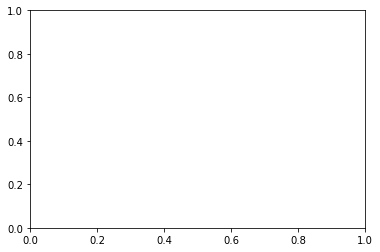

In [57]:
Scatter_temp20 = Weather_Data_2020_df['Temp Max']
Scatter_waterlvl20 = J17_2020_df['WaterLevelElevation']
plt.scatter(Scatter_temp20, Scatter_waterlvl20, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level 2020")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")

In [21]:
#
#Plot a bar chart using Humidity vs Water level to show correlation
#explorepossible analysis

In [22]:
#
#Plot a bar chart using Percipitation vs Water level to show correlation
#explorepossible analysis